# **1. Data Cleaning**

## (1) Filter out the games with evaluation scores

### 1) Load the original data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore', category=pd.errors.PerformanceWarning)

orig = pd.read_csv("chess_games.csv")
orig.head(3)

,Event,White,Black,Result,UTCDate,UTCTime,WhiteElo,BlackElo,WhiteRatingDiff,BlackRatingDiff,ECO,Opening,TimeControl,Termination,AN
0,Classical,eisaaaa,HAMID449,1-0,2016.06.30,22:00:01,1901,1896,11.0,-11.0,D10,Slav Defense,300+5,Time forfeit,1. d4 d5 2. c4 c6 3. e3 a6 4. Nf3 e5 5. cxd5 e...
1,Blitz,go4jas,Sergei1973,0-1,2016.06.30,22:00:01,1641,1627,-11.0,12.0,C20,King's Pawn Opening: 2.b3,300+0,Normal,1. e4 e5 2. b3 Nf6 3. Bb2 Nc6 4. Nf3 d6 5. d3 ...
2,Blitz tournament,Evangelistaizac,kafune,1-0,2016.06.30,22:00:02,1647,1688,13.0,-13.0,B01,Scandinavian Defense: Mieses-Kotroc Variation,180+0,Time forfeit,1. e4 d5 2. exd5 Qxd5 3. Nf3 Bg4 4. Be2 Nf6 5....


### 2) Filter evaluated games

In [2]:
eval_games = orig[orig['AN'].str.contains('{')]
eval_games = eval_games.reset_index(drop=True)
eval_games = eval_games.drop(['White', 'Black', 'UTCDate', 'UTCTime', 'WhiteRatingDiff', 'BlackRatingDiff', 'Opening', 'TimeControl'], axis=1)
eval_games.head(3)

,Event,Result,WhiteElo,BlackElo,ECO,Termination,AN
0,Blitz tournament,1-0,1761,1754,C30,Time forfeit,1. e4 { [%eval 0.27] } 1... e5 { [%eval 0.27] ...
1,Blitz tournament,1-0,2134,2128,B21,Normal,1. e4 { [%eval 0.31] } 1... c5 { [%eval 0.37] ...
2,Bullet tournament,1-0,1964,1970,B00,Time forfeit,1. e4 { [%eval 0.27] } 1... b6 { [%eval 0.51] ...


In [3]:
print(f"There are a total of {len(eval_games)} evaluated games.")
print(f"{round(len(eval_games)/len(orig)*100, 2)}% of games have evaluations.")

There are a total of 800496 evaluated games.
12.8% of games have evaluations.


## (2) Extract data from movement data: ```AN``` column 

In [4]:
# unique termination types
np.unique(eval_games['Termination'])

array(['Normal', 'Rules infraction', 'Time forfeit'], dtype=object)

### 1) Get total game movements

In [5]:
import re

def extract_last_move_number(an):
    an = re.sub('\{.*?\}', '', an)
    matches = re.findall('\d+[\.]{1,3}', an)
    if len(matches) > 0:
        last_move_number = matches[-1].strip('. ')
        return int(last_move_number)

eval_games['MovesCount'] = eval_games['AN'].apply(extract_last_move_number)

eval_games.head(3)

,Event,Result,WhiteElo,BlackElo,ECO,Termination,AN,MovesCount
0,Blitz tournament,1-0,1761,1754,C30,Time forfeit,1. e4 { [%eval 0.27] } 1... e5 { [%eval 0.27] ...,31
1,Blitz tournament,1-0,2134,2128,B21,Normal,1. e4 { [%eval 0.31] } 1... c5 { [%eval 0.37] ...,56
2,Bullet tournament,1-0,1964,1970,B00,Time forfeit,1. e4 { [%eval 0.27] } 1... b6 { [%eval 0.51] ...,21


<Axes: xlabel='MovesCount', ylabel='Count'>

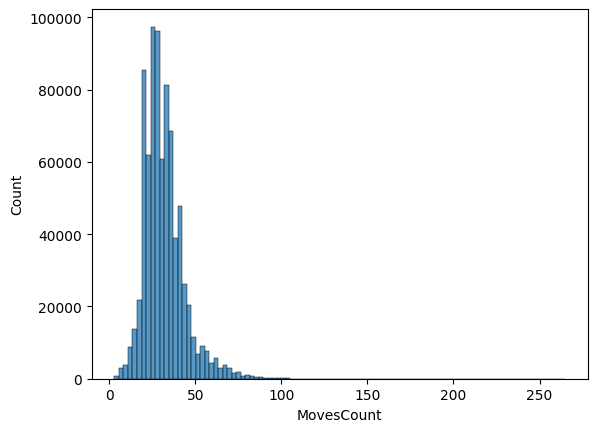

In [6]:
# Distribution of MovesCount
sns.histplot(eval_games['MovesCount'], kde=False, bins=100)

### 2) Remove the games with outlier ```MovesCount```

In [7]:
q1, q3 = np.percentile(eval_games['MovesCount'], [25, 75])
iqr = q3 - q1
lower_bound = q1 - 1.5*iqr
upper_bound = q3 + 1.5*iqr

# Filter the rows with 'MovesCount' within the upper/lower bounds
eval_games_filtered = eval_games[(eval_games['MovesCount'] >= lower_bound) & (eval_games['MovesCount'] <= upper_bound)]

print(f"{np.round(len(eval_games_filtered) / len(eval_games), 2) * 100}% of the games are retained after filtering")

96.0% of the games are retained after filtering


In [8]:
# Show the filtered dataframe
eval_games_filtered.head(3)

,Event,Result,WhiteElo,BlackElo,ECO,Termination,AN,MovesCount
0,Blitz tournament,1-0,1761,1754,C30,Time forfeit,1. e4 { [%eval 0.27] } 1... e5 { [%eval 0.27] ...,31
1,Blitz tournament,1-0,2134,2128,B21,Normal,1. e4 { [%eval 0.31] } 1... c5 { [%eval 0.37] ...,56
2,Bullet tournament,1-0,1964,1970,B00,Time forfeit,1. e4 { [%eval 0.27] } 1... b6 { [%eval 0.51] ...,21


## (3) Filter the game termination factors

### 1) Time Forfeits

In [9]:
time_forfeits = eval_games_filtered[eval_games_filtered['Termination'] == 'Time forfeit']
time_forfeits.head(3)

,Event,Result,WhiteElo,BlackElo,ECO,Termination,AN,MovesCount
0,Blitz tournament,1-0,1761,1754,C30,Time forfeit,1. e4 { [%eval 0.27] } 1... e5 { [%eval 0.27] ...,31
2,Bullet tournament,1-0,1964,1970,B00,Time forfeit,1. e4 { [%eval 0.27] } 1... b6 { [%eval 0.51] ...,21
6,Classical,0-1,1597,1761,C00,Time forfeit,1. e4 { [%eval 0.22] } 1... e6 { [%eval 0.41] ...,35


In [10]:
normals = eval_games_filtered[eval_games_filtered['Termination'] == 'Normal']
normals.head(3)

,Event,Result,WhiteElo,BlackElo,ECO,Termination,AN,MovesCount
1,Blitz tournament,1-0,2134,2128,B21,Normal,1. e4 { [%eval 0.31] } 1... c5 { [%eval 0.37] ...,56
3,Blitz tournament,0-1,1515,1540,C42,Normal,1. e4 { [%eval 0.22] } 1... e5 { [%eval 0.25] ...,26
4,Blitz,1-0,1422,1403,D00,Normal,1. d4 { [%eval 0.24] } 1... d5 { [%eval 0.14] ...,31


In [11]:
total_len = len(time_forfeits) + len(normals)

# print the percentage of time forfeits
print(f"{np.round(len(time_forfeits) / total_len, 2) * 100}% of the games are time forfeits")

30.0% of the games are time forfeits


### 2) Checkmates

In [12]:
def fiter_checkmates(raw_moves):
    moves = re.split(r'\d+\.\s', raw_moves)
    moves = [move.strip() for move in moves if move]
    endpoint = re.sub(r'\{.*?\}', '', moves[-1]).strip()

    if '#' in endpoint:
        return True
    else:
        return False

In [13]:
normals['Checkmate'] = normals['AN'].apply(fiter_checkmates)
checkmates = normals[normals['Checkmate'] == True]
checkmates = checkmates.drop(['Checkmate'], axis=1)
checkmates['Termination'] = 'Checkmate'
checkmates.head(3)

/var/folders/3b/h5pkwjcn3lv68t_r_r1x1dm00000gn/T/ipykernel_16031/1289764870.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  normals['Checkmate'] = normals['AN'].apply(fiter_checkmates)


,Event,Result,WhiteElo,BlackElo,ECO,Termination,AN,MovesCount
4,Blitz,1-0,1422,1403,D00,Checkmate,1. d4 { [%eval 0.24] } 1... d5 { [%eval 0.14] ...,31
8,Blitz,0-1,1693,1718,B54,Checkmate,1. e4 { [%eval 0.3] } 1... c5 { [%eval 0.25] }...,29
9,Classical,1-0,1577,1377,B40,Checkmate,1. e4 { [%eval 0.23] } 1... e6 { [%eval 0.2] }...,26


In [14]:
# print the percentage of checkmates
print(f"{np.round(len(checkmates) / total_len, 2) * 100}% of the games are checkmates")

28.999999999999996% of the games are checkmates


### 3) Resigns

In [15]:
resigns = normals[normals['Checkmate'] == True]
resigns = resigns.drop(['Checkmate'], axis=1)
resigns['Termination'] = 'Resignation'
resigns.head(3)

,Event,Result,WhiteElo,BlackElo,ECO,Termination,AN,MovesCount
4,Blitz,1-0,1422,1403,D00,Resignation,1. d4 { [%eval 0.24] } 1... d5 { [%eval 0.14] ...,31
8,Blitz,0-1,1693,1718,B54,Resignation,1. e4 { [%eval 0.3] } 1... c5 { [%eval 0.25] }...,29
9,Classical,1-0,1577,1377,B40,Resignation,1. e4 { [%eval 0.23] } 1... e6 { [%eval 0.2] }...,26


In [16]:
# print the percentage of resigns
print(f"{np.round(len(resigns) / total_len, 2) * 100} of the games are resigns")

28.999999999999996 of the games are resigns


### Merge all datasets back

In [17]:
filtered_games = pd.concat([time_forfeits, checkmates, resigns]).reset_index(drop=True)
filtered_games.head(3)

,Event,Result,WhiteElo,BlackElo,ECO,Termination,AN,MovesCount
0,Blitz tournament,1-0,1761,1754,C30,Time forfeit,1. e4 { [%eval 0.27] } 1... e5 { [%eval 0.27] ...,31
1,Bullet tournament,1-0,1964,1970,B00,Time forfeit,1. e4 { [%eval 0.27] } 1... b6 { [%eval 0.51] ...,21
2,Classical,0-1,1597,1761,C00,Time forfeit,1. e4 { [%eval 0.22] } 1... e6 { [%eval 0.41] ...,35


## (4) Pre-game data extraction

### 1) Defining ```MovesCount``` for the respective pre-game

#### **Case 1: Castling involved**
If only a single castling is involved, until that moment will be considered as pre-game. Otherwise if two castling is involved, the pre-game moment will be until the second castling has been made.

In [18]:
def extract_castle_move(raw_moves, total_moves):
    # Find the move number where castling has occurred
    matches = re.findall('(\d+)\.+\s+(O-O-O|O-O)', raw_moves)

    if len(matches) == 1:
        castle_move = int(matches[0][0])
        if castle_move == total_moves:
            castle_move = castle_move // 2

        return castle_move
    
    elif len(matches) == 2:
        castle_move = int(matches[1][0])
        if castle_move == total_moves:
            castle_move = castle_move // 2

        return castle_move
    
    else:
        return 0

# Add a new column 'CastleMove' to the 'eval_games_filtered' dataframe
filtered_games.loc[:, 'CastleMove'] = filtered_games.apply(
    lambda row: extract_castle_move(row['AN'], row['MovesCount']), axis=1)

# Show the updated dataframe
filtered_games.head(3)

,Event,Result,WhiteElo,BlackElo,ECO,Termination,AN,MovesCount,CastleMove
0,Blitz tournament,1-0,1761,1754,C30,Time forfeit,1. e4 { [%eval 0.27] } 1... e5 { [%eval 0.27] ...,31,13
1,Bullet tournament,1-0,1964,1970,B00,Time forfeit,1. e4 { [%eval 0.27] } 1... b6 { [%eval 0.51] ...,21,10
2,Classical,0-1,1597,1761,C00,Time forfeit,1. e4 { [%eval 0.22] } 1... e6 { [%eval 0.41] ...,35,18


In [19]:
castlings = filtered_games[filtered_games['CastleMove'] > 0]
castlings['PG-MovesCount'] = castlings['CastleMove']
castlings.drop(['MovesCount', 'CastleMove'], axis=1, inplace=True)
castlings.head(3)

/var/folders/3b/h5pkwjcn3lv68t_r_r1x1dm00000gn/T/ipykernel_16031/41711411.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  castlings['PG-MovesCount'] = castlings['CastleMove']
/var/folders/3b/h5pkwjcn3lv68t_r_r1x1dm00000gn/T/ipykernel_16031/41711411.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  castlings.drop(['MovesCount', 'CastleMove'], axis=1, inplace=True)


,Event,Result,WhiteElo,BlackElo,ECO,Termination,AN,PG-MovesCount
0,Blitz tournament,1-0,1761,1754,C30,Time forfeit,1. e4 { [%eval 0.27] } 1... e5 { [%eval 0.27] ...,13
1,Bullet tournament,1-0,1964,1970,B00,Time forfeit,1. e4 { [%eval 0.27] } 1... b6 { [%eval 0.51] ...,10
2,Classical,0-1,1597,1761,C00,Time forfeit,1. e4 { [%eval 0.22] } 1... e6 { [%eval 0.41] ...,18


#### **Case 2: No Castling involved**
Take the games with ```MovesCount``` in between 21 and 33, then divide by two; until that point will be the pre-game. Here, 21 and 33 are the min and max values of the quantile range.

In [20]:
zero_castle_moves = filtered_games[filtered_games['CastleMove'] == 0]
zero_castle_moves.head(3)

,Event,Result,WhiteElo,BlackElo,ECO,Termination,AN,MovesCount,CastleMove
13,Bullet,0-1,1492,1548,A21,Time forfeit,1. c4 { [%eval 0.0] } 1... e5 { [%eval -0.03] ...,40,0
32,Blitz,0-1,1500,1412,A46,Time forfeit,1. d4 { [%eval 0.2] } 1... Nf6 { [%eval 0.2] }...,39,0
80,Bullet tournament,1-0,1971,1682,A45,Time forfeit,1. d4 { [%eval 0.22] } 1... Nf6 { [%eval 0.18]...,39,0


In [21]:
zero_freq = zero_castle_moves['MovesCount'].value_counts().sort_index()
zero_freq = pd.DataFrame({
    'MovesCount': zero_freq.index,
    'Frequency': zero_freq.values
})
zero_freq.head(3)

,MovesCount,Frequency
0,5,221
1,6,332
2,7,581


In [22]:
zero_freq['CumulativeSum'] = zero_freq['Frequency'].cumsum()
total_sum = zero_freq['Frequency'].sum()
q1, q3 = total_sum * np.array([0.25, 0.75])

quantile_range = zero_freq.loc[(zero_freq['CumulativeSum'] >= q1) & (zero_freq['CumulativeSum'] <= q3)]

In [23]:
print(f'min (q1): {quantile_range["MovesCount"].head(1).values[0]}')
print(f'max (q3): {quantile_range["MovesCount"].tail(1).values[0]}')

min (q1): 19
max (q3): 31


In [24]:
zero_castle_moves_filtered = zero_castle_moves[(zero_castle_moves['MovesCount'] >= 19) & (zero_castle_moves['MovesCount'] <= 31)]
zero_castle_moves_filtered['PG-MovesCount'] = zero_castle_moves_filtered['MovesCount'].apply(lambda x: x // 2)
zero_castle_moves_filtered.drop(['MovesCount', 'CastleMove'], axis=1, inplace=True)
zero_castle_moves_filtered.head(3)

/var/folders/3b/h5pkwjcn3lv68t_r_r1x1dm00000gn/T/ipykernel_16031/4168798919.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zero_castle_moves_filtered['PG-MovesCount'] = zero_castle_moves_filtered['MovesCount'].apply(lambda x: x // 2)
/var/folders/3b/h5pkwjcn3lv68t_r_r1x1dm00000gn/T/ipykernel_16031/4168798919.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zero_castle_moves_filtered.drop(['MovesCount', 'CastleMove'], axis=1, inplace=True)


,Event,Result,WhiteElo,BlackElo,ECO,Termination,AN,PG-MovesCount
165,Classical,0-1,1151,1399,C20,Time forfeit,1. e4 { [%eval 0.31] } 1... e5 { [%eval 0.31] ...,11
187,Bullet tournament,0-1,1470,2053,A03,Time forfeit,1. f4 { [%eval -0.22] } 1... Nf6 { [%eval -0.2...,15
228,Blitz,1-0,1151,1204,B21,Time forfeit,1. e4 { [%eval 0.13] } 1... c5 { [%eval 0.31] ...,13


#### Merge datasets back

In [25]:
pg_games = pd.concat([castlings, zero_castle_moves_filtered]).reset_index(drop=True)
pg_games.head(3)

,Event,Result,WhiteElo,BlackElo,ECO,Termination,AN,PG-MovesCount
0,Blitz tournament,1-0,1761,1754,C30,Time forfeit,1. e4 { [%eval 0.27] } 1... e5 { [%eval 0.27] ...,13
1,Bullet tournament,1-0,1964,1970,B00,Time forfeit,1. e4 { [%eval 0.27] } 1... b6 { [%eval 0.51] ...,10
2,Classical,0-1,1597,1761,C00,Time forfeit,1. e4 { [%eval 0.22] } 1... e6 { [%eval 0.41] ...,18


### 2) Count and Score Mistakes

In [26]:
def white_score_mistakes(raw_moves, pg_moves_count):
    moves = re.split(r'\d+\.\s', raw_moves)
    moves = [move.strip() for move in moves if move]

    score = 0
    
    for i in range(pg_moves_count):
        if '??' in moves[i]:
            score += 4
        elif '?!' in moves[i]:
            score += 1
        elif '?' in moves[i]:
            score += 2
    
    return score

def black_score_mistakes(raw_moves, pg_moves_count):
    moves = re.split(r'\d+\...\s', raw_moves)
    moves = [move.strip() for move in moves if move]

    score = 0
    
    for i in range(pg_moves_count):
        if '??' in moves[i]:
            score += 4
        elif '?!' in moves[i]:
            score += 1
        elif '?' in moves[i]:
            score += 2
    
    return score

In [27]:
pg_games['White-Mistakes'] = pg_games.apply(lambda row: white_score_mistakes(row['AN'], row['PG-MovesCount']), axis=1)
pg_games['Black-Mistakes'] = pg_games.apply(lambda row: black_score_mistakes(row['AN'], row['PG-MovesCount']), axis=1)
pg_games.head(3)

,Event,Result,WhiteElo,BlackElo,ECO,Termination,AN,PG-MovesCount,White-Mistakes,Black-Mistakes
0,Blitz tournament,1-0,1761,1754,C30,Time forfeit,1. e4 { [%eval 0.27] } 1... e5 { [%eval 0.27] ...,13,8,12
1,Bullet tournament,1-0,1964,1970,B00,Time forfeit,1. e4 { [%eval 0.27] } 1... b6 { [%eval 0.51] ...,10,2,2
2,Classical,0-1,1597,1761,C00,Time forfeit,1. e4 { [%eval 0.22] } 1... e6 { [%eval 0.41] ...,18,11,7


### 3) pre-game Evaluation Scores

In [28]:
def extract_eval_score(an, move_count):
    pattern = r"\b" + str(move_count) + r"\.\s\w*\W*\w*\W*\w*\W*\s\{\s\[%eval\s(-?\d+(\.\d+)?|#-?\d+)\]\s\}"
    match = re.search(pattern, an)
    if match:
        eval_score = match.group(1)
        if eval_score.startswith("#-"):
            return -15.00
        elif eval_score.startswith("#"):
            return 15.00
        else:
            return float(eval_score)
    else:
        return None

pg_games['Eval-Score'] = pg_games.apply(lambda row: extract_eval_score(row['AN'], row['PG-MovesCount']), axis=1)
pg_games.head(3)

,Event,Result,WhiteElo,BlackElo,ECO,Termination,AN,PG-MovesCount,White-Mistakes,Black-Mistakes,Eval-Score
0,Blitz tournament,1-0,1761,1754,C30,Time forfeit,1. e4 { [%eval 0.27] } 1... e5 { [%eval 0.27] ...,13,8,12,-0.34
1,Bullet tournament,1-0,1964,1970,B00,Time forfeit,1. e4 { [%eval 0.27] } 1... b6 { [%eval 0.51] ...,10,2,2,-0.03
2,Classical,0-1,1597,1761,C00,Time forfeit,1. e4 { [%eval 0.22] } 1... e6 { [%eval 0.41] ...,18,11,7,2.40


In [29]:
# calculate 'W-WP' and 'B-WP' columns
pg_games['Eval-Score'] = pg_games['Eval-Score'].astype(float)
pg_games['W-WP'] = 1 / (1 + 10 ** (-pg_games['Eval-Score'] / 4))
pg_games['B-WP'] = 1 - pg_games['W-WP']
pg_games.drop(['Eval-Score'], axis=1, inplace=True)
pg_games.head(3)

,Event,Result,WhiteElo,BlackElo,ECO,Termination,AN,PG-MovesCount,White-Mistakes,Black-Mistakes,W-WP,B-WP
0,Blitz tournament,1-0,1761,1754,C30,Time forfeit,1. e4 { [%eval 0.27] } 1... e5 { [%eval 0.27] ...,13,8,12,0.451226,0.548774
1,Bullet tournament,1-0,1964,1970,B00,Time forfeit,1. e4 { [%eval 0.27] } 1... b6 { [%eval 0.51] ...,10,2,2,0.495683,0.504317
2,Classical,0-1,1597,1761,C00,Time forfeit,1. e4 { [%eval 0.22] } 1... e6 { [%eval 0.41] ...,18,11,7,0.799240,0.200760


### 3) Expected Scores of White/Black
### 4) White/Black Superiority with Frequently Used Opening
### 5) Overall Dataset Organization

In [30]:
import math

def organize_features(df):

    df_cpy = df.copy()

    # Game Result
    df_cpy['W'] = df_cpy['Result'].apply(lambda x: 1 if x == '1-0' else 0)
    df_cpy['B'] = df_cpy['Result'].apply(lambda x: 1 if x == '0-1' else 0)

    # Expected Score
    def expected_score(side, ra, rb):
        if side == "W":
            diff = rb - ra
        elif side == "B":
            diff = ra - rb
        
        return 1 / (1 + math.pow(10, diff / 400))
    
    elos = df_cpy[["WhiteElo", "BlackElo"]]

    elos = elos.assign(W_ES=elos.apply(lambda row: expected_score("W", row["WhiteElo"], row["BlackElo"]), axis=1))
    elos = elos.assign(B_ES=elos.apply(lambda row: expected_score("B", row["WhiteElo"], row["BlackElo"]), axis=1)) 

    df_cpy = pd.concat([df_cpy, elos[["W_ES", "B_ES"]]], axis=1)

    df_cpy = df_cpy[['Event', 'WhiteElo', 'W_ES', 'BlackElo', 'B_ES', 
                     'ECO', 'PG-MovesCount', 'White-Mistakes', 'Black-Mistakes', 'W-WP', 'B-WP',
                     'AN', 'W', 'B', 'Termination']]
    
    return df_cpy


In [31]:
pg_games = organize_features(pg_games)
pg_games.head(3)

,Event,WhiteElo,W_ES,BlackElo,B_ES,ECO,PG-MovesCount,White-Mistakes,Black-Mistakes,W-WP,B-WP,AN,W,B,Termination
0,Blitz tournament,1761,0.510072,1754,0.489928,C30,13,8,12,0.451226,0.548774,1. e4 { [%eval 0.27] } 1... e5 { [%eval 0.27] ...,1,0,Time forfeit
1,Bullet tournament,1964,0.491366,1970,0.508634,B00,10,2,2,0.495683,0.504317,1. e4 { [%eval 0.27] } 1... b6 { [%eval 0.51] ...,1,0,Time forfeit
2,Classical,1597,0.280081,1761,0.719919,C00,18,11,7,0.799240,0.200760,1. e4 { [%eval 0.22] } 1... e6 { [%eval 0.41] ...,0,1,Time forfeit


### Additional Cleanings

In [32]:
def process_events(df):

    df_cpy = df.copy()

    def cat_events(event):

        if "Classical" in event:
            return "Classical"
        
        elif "Blitz" in event:
            return "Blitz"

        elif "Bullet" in event:
            return "Bullet"
        
        elif "Correspondence" in event:
            return "Correspondence"
    
    df_cpy['Event'] = df_cpy['Event'].apply(cat_events)

    return df_cpy

In [33]:
pg_games = process_events(pg_games)
pg_games.head(3)

,Event,WhiteElo,W_ES,BlackElo,B_ES,ECO,PG-MovesCount,White-Mistakes,Black-Mistakes,W-WP,B-WP,AN,W,B,Termination
0,Blitz,1761,0.510072,1754,0.489928,C30,13,8,12,0.451226,0.548774,1. e4 { [%eval 0.27] } 1... e5 { [%eval 0.27] ...,1,0,Time forfeit
1,Bullet,1964,0.491366,1970,0.508634,B00,10,2,2,0.495683,0.504317,1. e4 { [%eval 0.27] } 1... b6 { [%eval 0.51] ...,1,0,Time forfeit
2,Classical,1597,0.280081,1761,0.719919,C00,18,11,7,0.799240,0.200760,1. e4 { [%eval 0.22] } 1... e6 { [%eval 0.41] ...,0,1,Time forfeit


In [34]:
pg_games.to_csv('./data/cleaned_chess_games.csv', index=False)